# Проект - Временные ряды

## Описание проекта

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## Последовательность выполнения проекта

- Загрузим данные и выполним их ресемплирование по одному часу.
- Проанализируем данные.
- Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
- Проверим данные на тестовой выборке и сделать выводы.

## Описание данных

- Целевой признак - количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

# Выполнение проекта

## Выгрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

## Выгрузка данных

In [2]:
try:
    data=pd.read_csv('C:/Users/kaz-106/YandexDisk/Py-projects/02_Practicum projects/10_Time_series/taxi.csv', parse_dates=[0],index_col=[0])
except:
    data=pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0],index_col=[0])

data.sort_index(inplace=True)
print(data.index.is_monotonic)
data = data.resample('1H').sum()

True


## Анализ данных

- Данные показывают количество заказов такси с 01.03.2018 по 31.08.08.2018, данные разбиты по часам
- Монотонность данных выполняется, хронологический порядок верный
- Ряд нестационарный, скользящее среднее изменяется

In [3]:
display(data.info())
display(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Тренды по месяцам и времени суток

- Количество заказов плавно увеличивается с начала лета, скорее всего это означает развитие компании
- Ожидаемо больше заказов в часы пик и ближе к ночи (когда не ходит общественный траспорт)

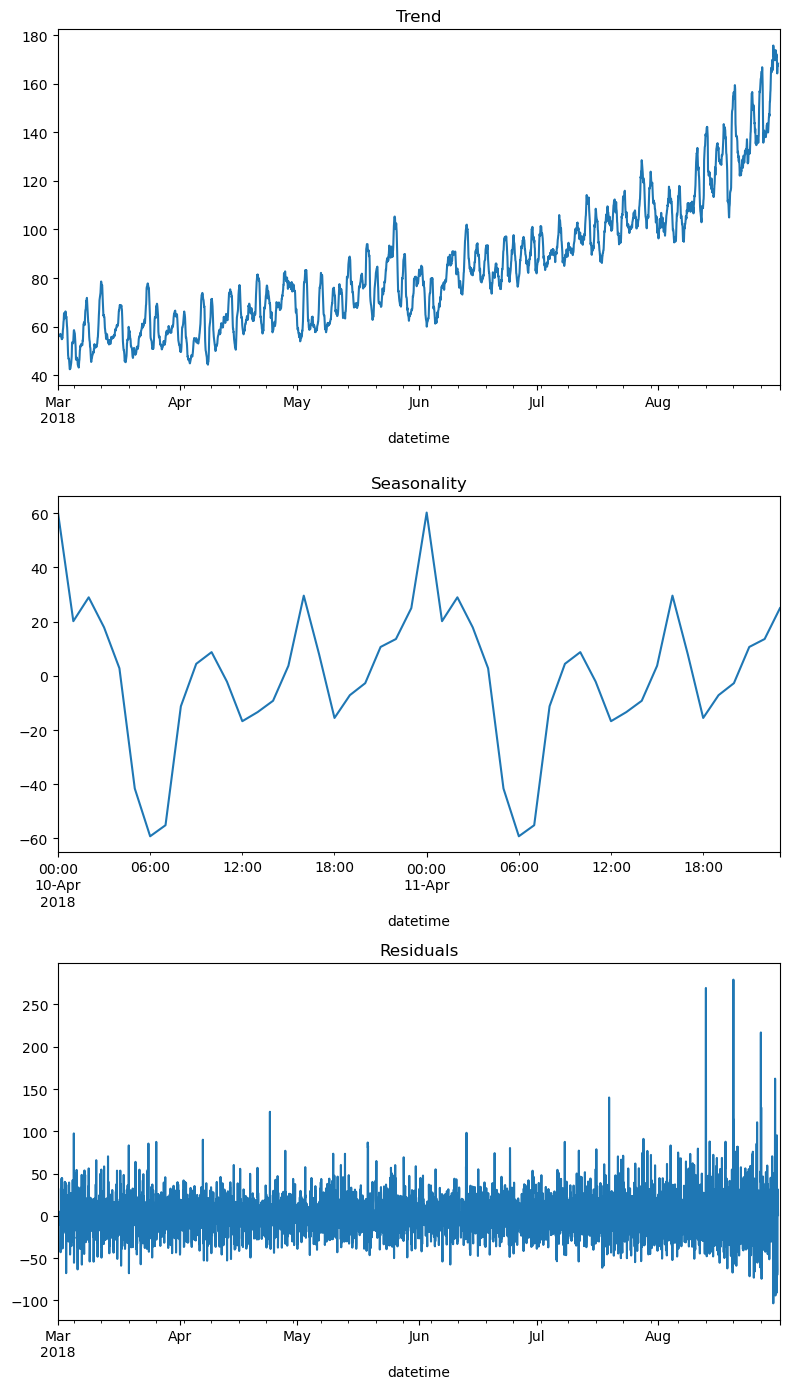

In [4]:
decompose = seasonal_decompose(data)

plt.figure(figsize=(8, 14))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decompose.seasonal['2018-04-10':'2018-04-11'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

### Скользящее среднее

<AxesSubplot:xlabel='datetime'>

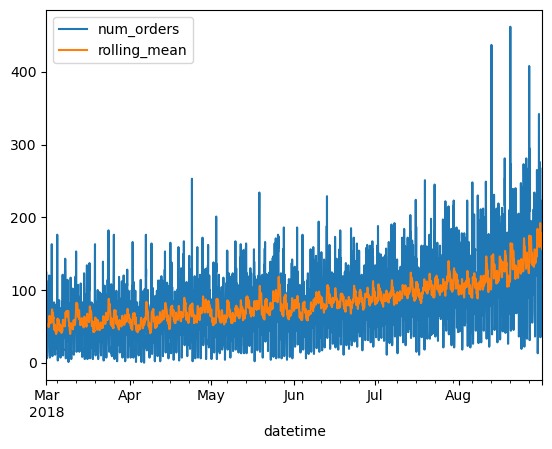

In [5]:
data['rolling_mean'] = data.rolling(20).mean()
data.plot()

## Обучение моделей

### Функция для создания признаков

In [6]:
def make_features(data, max_lag, rolling_mean_size):
#    data['year'] = data.index.year
#    data['month'] = data.index.month
#    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 50,50)
display(data)

,num_orders,rolling_mean,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,169.64,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0,159.0
2018-08-31 20:00:00,154,169.18,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0,120.0
2018-08-31 21:00:00,159,169.86,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,186.0,193.0,232.0,217.0,216.0,265.0,177.0,170.0,191.0,169.0


### Модель линейной регресии

In [7]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']

test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

model = LinearRegression()

model.fit(train_features, train_target)
train_predict=model.predict(train_features)

print("RMSE обучающей выборки:", mean_squared_error(train_target, train_predict)**0.5)
Linearresult=mean_squared_error(train_target, train_predict)**0.5

RMSE обучающей выборки: 23.4341370821779


### Модель CatBoost

In [8]:
CatBoost_model = CatBoostRegressor(l2_leaf_reg=20,n_estimators=50, max_depth=5,loss_function = 'RMSE',eval_metric = 'RMSE')
CatBoost_model.fit(train_features, train_target,verbose=10)

train_predict=CatBoost_model.predict(train_features)

print("RMSE обучающей выборки:", mean_squared_error(train_target, train_predict)**0.5)
CatBoost_result=mean_squared_error(train_target, train_predict)**0.5

0:	learn: 38.2049853	total: 141ms	remaining: 6.89s
10:	learn: 33.9547646	total: 183ms	remaining: 650ms
20:	learn: 30.9338699	total: 222ms	remaining: 307ms
30:	learn: 28.7837808	total: 252ms	remaining: 154ms
40:	learn: 27.2855046	total: 279ms	remaining: 61.3ms
49:	learn: 26.2780878	total: 305ms	remaining: 0us
RMSE обучающей выборки: 26.278087788797087


In [9]:
#param_grid = {'n_estimators':[10,50],
#              'max_depth': [5,10],
#              }
#CatBoost_model = CatBoostRegressor(loss_function="RMSE")
#tscv = TimeSeriesSplit(n_splits=5)                                
#parameters_CatBoost = GridSearchCV(estimator = CatBoost_model,param_grid = param_grid,n_jobs=-1,verbose=1,scoring= 'neg_root_mean_squared_error',cv=tscv)
#
#parameters_CatBoost.fit(train_features, train_target)
#print('best params\n', parameters_CatBoost.best_params_)
#print('best RMSE\n', parameters_CatBoost.best_score_)

### Модель LGBM

In [10]:
param_grid = {'max_depth':[5,10,15],
              'learning_rate': [0.05,0.1,0.15],
              }
LGBM_model = lgb.LGBMRegressor()
                                  
tscv = TimeSeriesSplit(n_splits=5) 

#Функция для перекрестной проверки временных рядов, обеспечивает чтобы индексы тестовой части были больше чем обучающей, чтобы поддерживать временную последовательность#
#Число разбиений примем равным 5, нигде не нашел как это можно подобрать#

parameters_LGBM = GridSearchCV(estimator = LGBM_model,param_grid = param_grid,n_jobs=-1,verbose=1,scoring= 'neg_root_mean_squared_error',cv=tscv)

parameters_LGBM.fit(train_features, train_target)
print('best params\n', parameters_LGBM.best_params_)
print('best RMSE\n', parameters_LGBM.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
best params
 {'learning_rate': 0.1, 'max_depth': 5}
best RMSE
 -24.152433799778798


In [11]:
LGBM_model = lgb.LGBMRegressor(num_leaves= 100, learning_rate=0.1, max_depth=5, n_estimators=200)
LGBM_model.fit(train_features, train_target, eval_metric='rmse')

train_predict=LGBM_model.predict(train_features)

print("RMSE обучающей выборки:", mean_squared_error(train_target, train_predict)**0.5)
LGBM_result=mean_squared_error(train_target, train_predict)**0.5

RMSE обучающей выборки: 11.80682794305644


## Сравнение моделей

In [12]:
result = {'Модель':['Linear','CatBoost','LGBM'],
          'RMSE':[Linearresult,CatBoost_result,LGBM_result],
          }

result=pd.DataFrame(result)

display(result)

,Модель,RMSE
0,Linear,23.434137
1,CatBoost,26.278088
2,LGBM,11.806828


## Финальное тестирование

- На обучающих выборках модель LGBM показала наилучшие результаты, будем использовать ее для финального тестирования
- в данном проекте, согласно заданию, не использовало разделение датасета на обучающую, тестовую и валидационную выборки, поэтому будем проводить финальное тестирование на тестовой выборке

In [13]:
test_predict=LGBM_model.predict(test_features)

print("RMSE тестовой выборки:", mean_squared_error(test_target, test_predict)**0.5)

RMSE тестовой выборки: 40.068427605795115


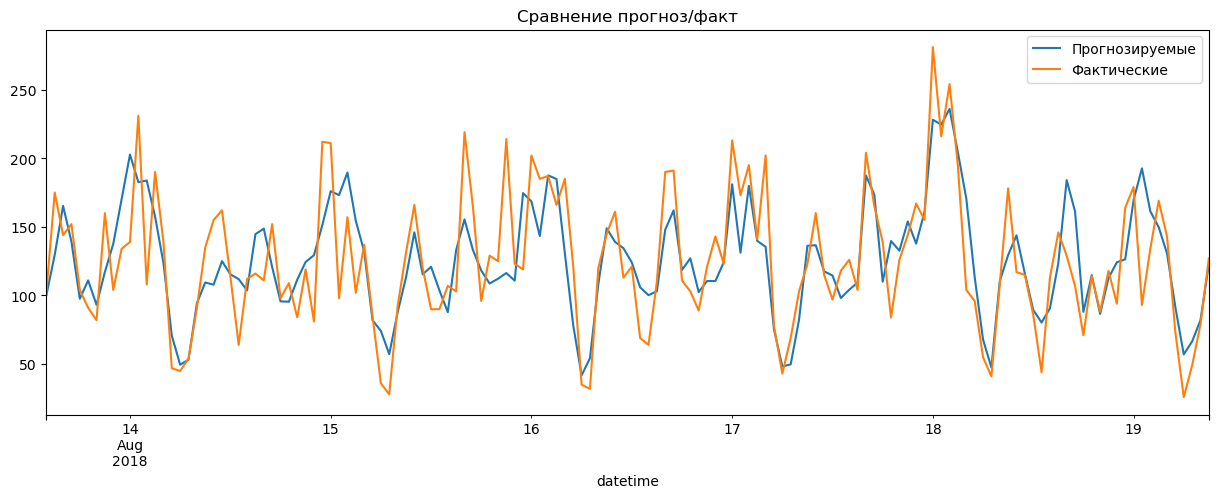

In [14]:
pd.DataFrame({'Прогнозируемые':test_predict, 'Фактические':test_target})[:140].plot(figsize=(15,5))
plt.title('Сравнение прогноз/факт')
plt.show()

## Выводы

- Данные выгружены, ресеплированы, проверена монотонность
- Проведен общий анализ, определены суточные и месячные тренды
- Созданы новые признаки для обучения моделей, подобраны параметры
- Обучены три разрличные модели машинного обучения (Линейная, CatBoost, LGBM), подобраны гиперпараметры
- Выбрана наилучая модель (по RMSE) и проведено ее финальное тестирование на тестовой выборке. RMSE не превышает значение, требуемое в условии